## Pneumonia Identification - A Neural Network Model

### Pneumonia infection 
Pneumonia is a common acute respiratory infectiom that affects the alveoli and distal airways. It is associated with high morbidity and is a major health problem with both short term and long term affects. Pneumonia is also widespread occuring in all parts of the globe across all age groups. It is more common in the very young (< 5 years of age) and older adults, particularly amonsgt those who suffer from other health conditions. Nearly one million children per year lose their lives to pneumonia and related causes. The causes of pneumonia have multiple vectors - viral, bacterial, and fungal. Individuals with pneumonia face both respiratory and systemic symptoms. Accurate diagnosis of the infection requires both clinical and radiological (x-ray) methods. Rapid and accurate diagnosis is also crucial to successful treatment, often with a range of antimicrobial therapies.  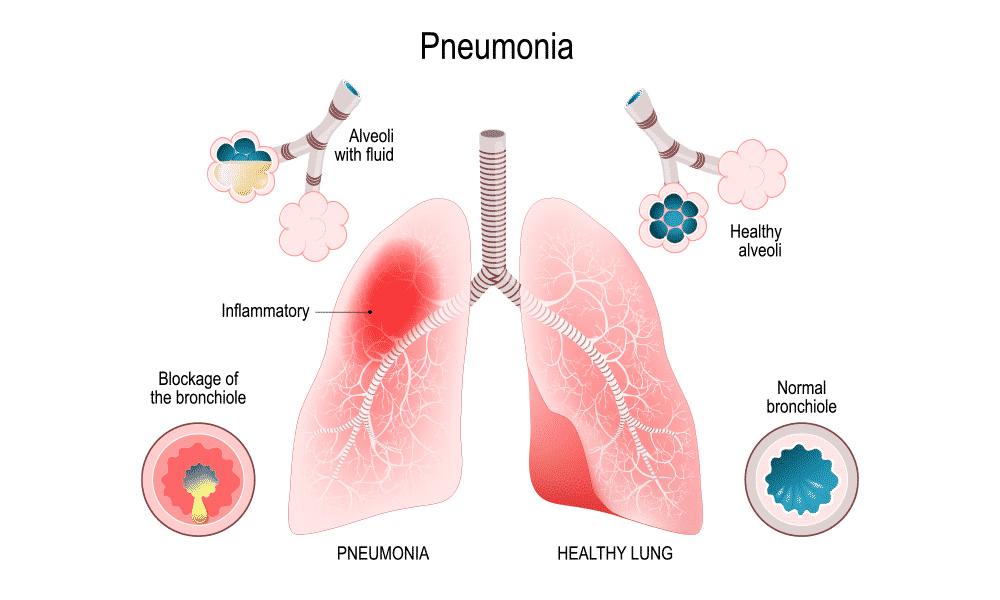

#### Business Case - Intermountain Health Care
Intermountain Health Care (IHC) is a not-for-profit healthcare system based in Utah. Over the past several years they have been working to extend their reach to rural areas. IHC now operates nine hospitals and 23 rural community medical clinics. Despite their reach they face a shortage of medical specialists, particularly radiologists.  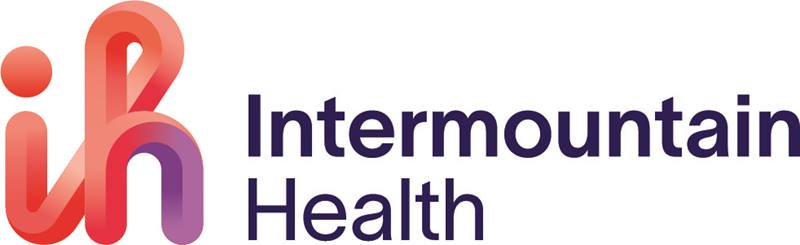

According to the Association of American Medical Colleges there is a growing shortage of trained medical specialist, especially in radiology, psychiatry, and pathology. On average, the number of medical imaging studies increases by a rate of up to five percent per year, but the number of radiology residency positions only increases by two percent. Decreased numbers of radiologists increases the time to make an accurate diagnosis. IHC cannot meet the demand for trained radiologists across their hospital system. The turnaround time for accurate imaging diagnosis is increasing which impacts patient care and outcomes. IHC is looking for a data science imaging solution.

In [212]:
import numpy as np # forlinear algebra
import matplotlib.pyplot as plt #for plotting things
import os, shutil
from PIL import Image
import scipy
from scipy import ndimage

# Keras Libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(123)

### Notebook Data Flow

#### Load Data -->   Process Data for Modeling -->    Baseline Model -->    CNN Model 1 -->   

####        Model 2 with Data Augmentation -->    Model 3 with added layering and padding -->                                    

####        Model 4 with regularization -->    Model 5 with Batch Normalization --> Model Evaluation  --> Recommendations

#### Dataset Description

The dataset contains a total of 5,856 x-ray images (anterior - posterior) of pediatric patients under the age of 5 years old. The dataset is divided into three folders made up of jpegs: training, validation, and test folders. Each folder contains two classes: Normal and Pneumonia. The images were previously labeled and validated by two expert physicians. To further reduce error a third expert validated their work. 

## Load Data 

In [2]:
train = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/train', labels = 'inferred', 
                                                            class_names = ['NORMAL', 'PNEUMONIA'])

Found 5216 files belonging to 2 classes.


In [3]:
test = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/test', labels = 'inferred',
                                                          class_names = ['NORMAL', 'PNEUMONIA'])

Found 624 files belonging to 2 classes.


In [4]:
val = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/val', labels = 'inferred',
                                                         class_names = ['NORMAL', 'PNEUMONIA'])

Found 16 files belonging to 2 classes.


Pediatric Lung Image - NORMAL


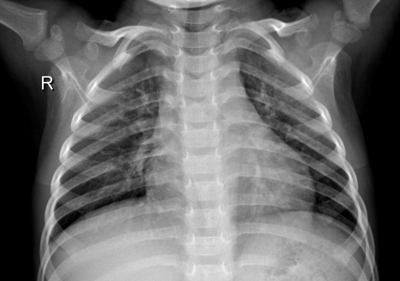

Pediatric Lung Image - PNEUMONIA (viral origins)


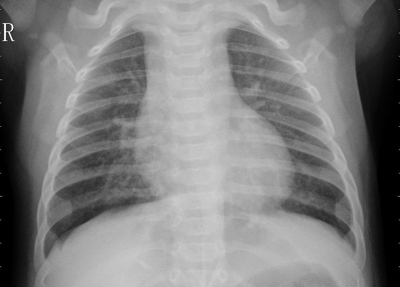

Pediatric Lung Image - PNEUMONIA (bacterial origins)


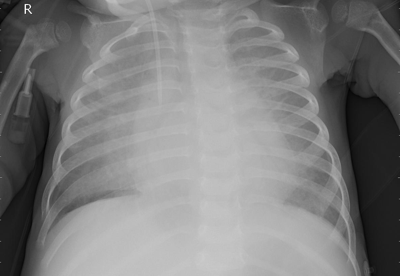

<Figure size 432x288 with 0 Axes>

In [537]:
#Display normal lung image

print('Pediatric Lung Image - NORMAL')

norm_img = Image.open('chest_xray/train/NORMAL/IM-0125-0001.jpeg')
norm_img.thumbnail((400, 400))
display(norm_img)
plt.savefig("normal_xray.png");

# Display pneumonia image with viral origins

print('Pediatric Lung Image - PNEUMONIA (viral origins)')

p_img = Image.open('chest_xray/train/PNEUMONIA/person1000_virus_1681.jpeg')
p_img.thumbnail((400, 400))
display(p_img)
plt.savefig("viral_xray.png");

# Display pneumonia image with bacterial origins

print('Pediatric Lung Image - PNEUMONIA (bacterial origins)')

p_img = Image.open('chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg')
p_img.thumbnail((400, 400))
display(p_img)
plt.savefig("bacteria_xray.png");


## Process the datasets for modeling

In [6]:
# Identify shape of each dataset
print('Shape and Datatype of Train dataset:', train)
print()
print('Shape and Datatype of Val dataset:', val)
print()
print('Shape and Datatype of Test dataset:', test)

Shape and Datatype of Train dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Shape and Datatype of Val dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Shape and Datatype of Test dataset: <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>


In [8]:
#identify file path
train_folder = 'chest_xray/train'
val_folder = 'chest_xray/val'
test_folder = 'chest_xray/test'

In [9]:
# get all the data in the directory, and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 624) 

# get all the data in the directory, and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 16)

# get all the data in the directory, and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size = 5216)

Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [57]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [10]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [12]:
#reshape for deep learning
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5216, 12288)
(624, 12288)
(16, 12288)


In [90]:
#check labels
train_labels[:10]

array([1., 0., 1., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [14]:
#reshape labels
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

In [15]:
# check data shapes
train_y.shape

(5216, 1)

In [16]:
test_y.shape

(624, 1)

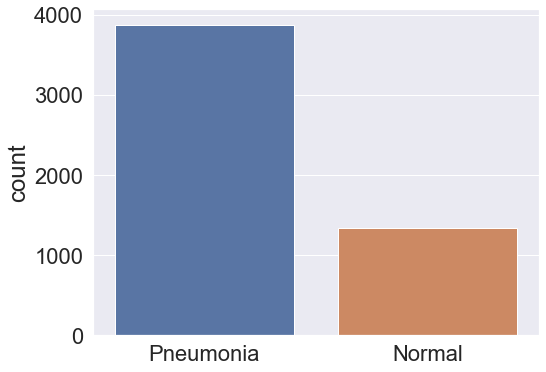

In [237]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

show_class = []
for i in train_y:
    if(i == 0):
        show_class.append("Pneumonia")
    else:
        show_class.append("Normal")
fig, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=2)
sns.set_style('darkgrid')
sns.countplot(show_class)
plt.savefig("class_imbalance_train.png");  

## 1. Build a baseline model

Build a simple baseline model using densely connected layers. 

In [243]:
# Neural network model
baseline_model = Sequential()

# No hidden layers

#Input
baseline_model.add(Dense(16, activation='relu', input_shape=(12288,))) 
baseline_model.add(Dense(7, activation='relu'))
baseline_model.add(Dense(5, activation='relu'))
# Binary output
baseline_model.add(Dense(1, activation='sigmoid'))

In [244]:
baseline_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

base_history = baseline_model.fit(train_img,
                    train_y,
                    epochs=20,
                    batch_size=32,
                    validation_split = 0.2)

Epoch 1/20
131/131 [==============================] - 1s 4ms/step - loss: 0.6644 - accuracy: 0.7181 - val_loss: 0.6289 - val_accuracy: 0.7759
Epoch 2/20
131/131 [==============================] - 0s 1ms/step - loss: 0.6247 - accuracy: 0.7347 - val_loss: 0.5932 - val_accuracy: 0.7759
Epoch 3/20
131/131 [==============================] - 0s 1ms/step - loss: 0.6032 - accuracy: 0.7347 - val_loss: 0.5711 - val_accuracy: 0.7759
Epoch 4/20
131/131 [==============================] - 0s 1ms/step - loss: 0.5893 - accuracy: 0.7347 - val_loss: 0.5562 - val_accuracy: 0.7759
Epoch 5/20
131/131 [==============================] - 0s 1ms/step - loss: 0.5776 - accuracy: 0.7347 - val_loss: 0.5415 - val_accuracy: 0.7759
Epoch 6/20
131/131 [==============================] - 0s 1ms/step - loss: 0.5586 - accuracy: 0.7347 - val_loss: 0.5170 - val_accuracy: 0.7759
Epoch 7/20
131/131 [==============================] - 0s 1ms/step - loss: 0.5125 - accuracy: 0.7610 - val_loss: 0.4784 - val_accuracy: 0.9205
Epoch 

#### Model Evaluation



In [245]:
# Baseline training results
base_results_train = baseline_model.evaluate(train_img, train_y)

163/163 [==============================] - 0s 1ms/step - loss: 0.1672 - accuracy: 0.9555


In [246]:
base_results_val = baseline_model.evaluate(val_img, val_y)

1/1 [==============================] - 0s 880us/step - loss: 0.2943 - accuracy: 0.9375


In [249]:
test_results_val = baseline_model.evaluate(test_img, test_y)

20/20 [==============================] - 0s 1ms/step - loss: 0.5359 - accuracy: 0.7788


In [250]:
#Print results for train and test
print("Baseline Results from Training Data:", base_results_train)
print()
print("Baseline Results from Validation Data:", base_results_val)



Baseline Results from Training Data: [0.16717903316020966, 0.9555214643478394]

Baseline Results from Validation Data: [0.2942536473274231, 0.9375]


In [253]:
# Plot train and test loss and accuracy
def visualize_training_results(results):
    sns.set(font_scale=1)
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

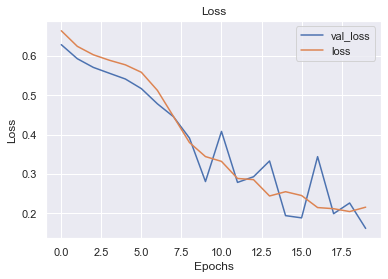

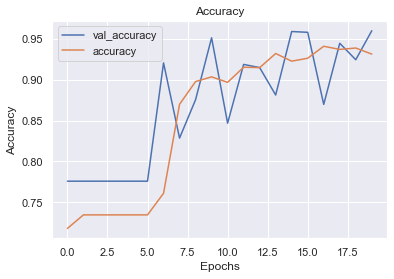

In [254]:
visualize_training_results(base_history)

#### Baseline Model summary 
The baseline model was generated with a densely layered neural network with two hidden layers. The training results scored 95.5% accuracy rate but the test score is at 77.9%. This model appears overfit and too sensitive to noise in the training dataset. 

## CNN Model - Model 1

Include convolution, and Dense layering - 2 hidden layers.

In [24]:
#Instantiate a CNN model

model_1 = Sequential()

# Add convolution layer

model_1.add(Conv2D(32, (3, 3), activation = 'relu',
                   input_shape = (64, 64, 3)))


# Add another convolution layer

model_1.add(Conv2D(64, (3, 3), activation='relu'))


# Flatten the model

model_1.add(Flatten())

# Add dense layers, two hidden

model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dense(7, activation = 'relu'))
model_1.add(Dense(5, activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_1.add(Dense(1))
model_1.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and rmsprop for optimizer

model_1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [25]:
# Examine the built model
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                14745664  
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 455       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [26]:
# Fit the model
history_1 = model_1.fit(train_images, 
                        train_y, 
                        epochs=20, 
                        validation_split = 0.2) 
                                

Epoch 1/20
131/131 [==============================] - 29s 220ms/step - loss: 0.6874 - accuracy: 0.7294 - val_loss: 0.6599 - val_accuracy: 0.7759
Epoch 2/20
131/131 [==============================] - 27s 208ms/step - loss: 0.6540 - accuracy: 0.7347 - val_loss: 0.6326 - val_accuracy: 0.7759
Epoch 3/20
131/131 [==============================] - 27s 210ms/step - loss: 0.6333 - accuracy: 0.7347 - val_loss: 0.6093 - val_accuracy: 0.7759
Epoch 4/20
131/131 [==============================] - 27s 202ms/step - loss: 0.6164 - accuracy: 0.7347 - val_loss: 0.5895 - val_accuracy: 0.7759
Epoch 5/20
131/131 [==============================] - 27s 203ms/step - loss: 0.6034 - accuracy: 0.7347 - val_loss: 0.5740 - val_accuracy: 0.7759
Epoch 6/20
131/131 [==============================] - 27s 203ms/step - loss: 0.5944 - accuracy: 0.7347 - val_loss: 0.5629 - val_accuracy: 0.7759
Epoch 7/20
131/131 [==============================] - 26s 202ms/step - loss: 0.5881 - accuracy: 0.7347 - val_loss: 0.5544 - val_ac

#### Model evaluation

In [27]:
results_1_train = model_1.evaluate(train_images, train_y)

163/163 [==============================] - 5s 31ms/step - loss: 0.5702 - accuracy: 0.7429


In [28]:
results_1_test = model_1.evaluate(test_images, test_y)

20/20 [==============================] - 1s 30ms/step - loss: 0.6898 - accuracy: 0.6250


In [29]:
#Print results for Model 1 train and test
print("Model 1 Results from Training Data:", results_1_train)
print()
print("Model 1 Results from Test Data:", results_1_test)



Model 1 Results from Training Data: [0.5702043175697327, 0.7429064512252808]

Model 1 Results from Test Data: [0.6898149847984314, 0.625]


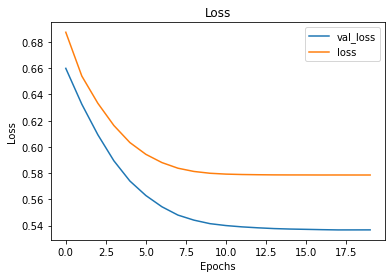

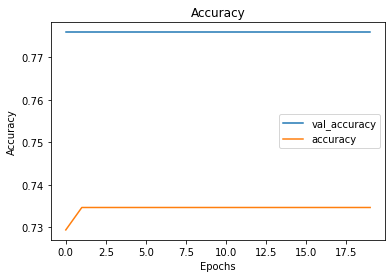

In [30]:
# Plot accuracy and loss
visualize_training_results(history_1)

#### Model Evaluation

Convolutional layers were added to a densely connected network, the optimizer was also changed to 'rmsprop'. The training dataset accuracy flatlines early on in the training process. The model is not able to generate new insight after a few epochs. The accuracy score is significantly smaller at 74% than baseline and is still overfitted as test accuracy score comes in lower as well at 62.5%

## Model 2 - Data Augmentation 
Add data augmentation to account for imbalance classes. Include Maxpooling after Convolution Layers 

In [303]:
# Augment the training and test data to account for class imbalance
train_datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=20, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.1, 
                             horizontal_flip=True, 
                             fill_mode = 'nearest',
                             validation_split = 0.12)

test_datagen = ImageDataGenerator(rescale = 1./255)

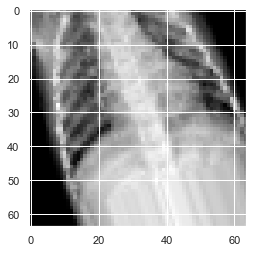

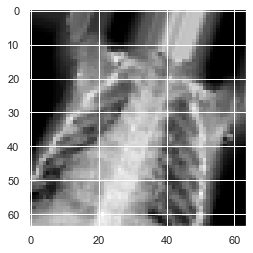

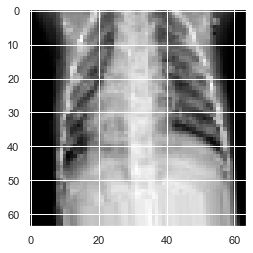

In [304]:
# View an augmented image

# Load image
img = load_img('chest_xray/train/NORMAL/IM-0125-0001.jpeg', target_size=(64, 64))

# Reshape
reshape_img = img_to_array(img) 
reshape_img = reshape_img.reshape((1,) + reshape_img.shape) 

# Run image through augmented image generator

i=0
for batch in train_datagen.flow(reshape_img, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
        break
        
plt.show()

In [305]:
# Set image size for shaping
img_size = 150

# Train generator - training subset
train_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(img_size, img_size), 
        batch_size = 32, 
        class_mode='binary', 
        subset = "training")

# Validation Generator - validation subset
val_generator = train_datagen.flow_from_directory(
        train_folder, 
        target_size=(img_size, img_size),
        batch_size = 32,
        class_mode='binary', 
        subset = "validation")

# Test Generator 
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(img_size, img_size), 
        batch_size = 624,
        class_mode='binary') 


Found 4591 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [306]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [307]:
train_labels.shape

(32,)

In [308]:
train_images.shape

(32, 150, 150, 3)

In [309]:
test_images.shape

(624, 150, 150, 3)

In [310]:
#Instantiate a CNN model

model_2 = Sequential()

# Add convolution layer

model_2.add(Conv2D(32, (3, 3), activation = 'relu',
                   input_shape= (img_size, img_size, 3)))

# Add a maxpooling layer

model_2.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolution layer

model_2.add(Conv2D(64, (4, 4), activation='relu'))

# Add another maxpooling layer

model_2.add(MaxPooling2D((2, 2)))

# Flatten the model

model_2.add(Flatten())

# Add dense layers

model_2.add(Dense(32, activation = 'relu'))

# Add the output layer for binary - normal or pneumonia

model_2.add(Dense(1))
model_2.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and rmsprop for optimizer

model_2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [311]:
model_2.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 71, 71, 64)        32832     
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 78400)             0         
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2508832   
_________________________________________________________________
dense_47 (Dense)             (None, 1)               

In [312]:
history_2 = model_2.fit(train_generator, 
                      steps_per_epoch = 50,
                      epochs=10, 
                      validation_data = val_generator,
                      validation_steps = 10,
                      verbose = 1)

Epoch 1/10
50/50 [==============================] - 38s 761ms/step - loss: 0.7462 - accuracy: 0.7331 - val_loss: 0.5750 - val_accuracy: 0.7500
Epoch 2/10
50/50 [==============================] - 38s 763ms/step - loss: 0.5760 - accuracy: 0.7231 - val_loss: 0.5450 - val_accuracy: 0.7688
Epoch 3/10
50/50 [==============================] - 38s 758ms/step - loss: 0.4352 - accuracy: 0.7844 - val_loss: 0.4794 - val_accuracy: 0.7875
Epoch 4/10
50/50 [==============================] - 38s 761ms/step - loss: 0.3846 - accuracy: 0.8188 - val_loss: 0.5770 - val_accuracy: 0.7812
Epoch 5/10
50/50 [==============================] - 38s 755ms/step - loss: 0.3666 - accuracy: 0.8294 - val_loss: 0.4155 - val_accuracy: 0.8031
Epoch 6/10
50/50 [==============================] - 37s 742ms/step - loss: 0.3567 - accuracy: 0.8431 - val_loss: 0.6231 - val_accuracy: 0.7688
Epoch 7/10
50/50 [==============================] - 37s 737ms/step - loss: 0.3317 - accuracy: 0.8550 - val_loss: 0.3564 - val_accuracy: 0.8250

#### Evaluate model

In [313]:
results_2_train = model_2.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 804us/step - loss: 0.3438 - accuracy: 0.8125


In [314]:
results_2_test = model_2.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 69ms/step - loss: 0.6509 - accuracy: 0.7179


In [315]:
results_2_val = model_2.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 939us/step - loss: 0.2944 - accuracy: 0.8125


In [316]:
#Print results for Model 1 train and test
print("Model 2 Results from Training Data:", results_2_train)
print()
print("Model 2 Results from Test Data:", results_2_test)


Model 2 Results from Training Data: [0.34381651878356934, 0.8125]

Model 2 Results from Test Data: [0.6509417295455933, 0.7179487347602844]


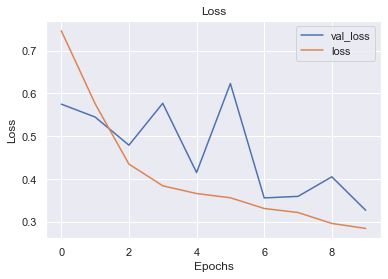

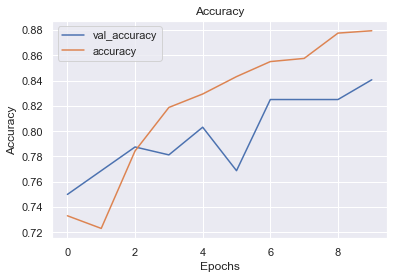

In [317]:
# Plot accuracy and loss
visualize_training_results(history_2)

#### CNN model summary 
Data augmentation was added to the datasets to address imbalances. Maxpooling was also introduced to consolidate features learned from the convolutional layers. Dense layers were reduced to eliminate hidden layers. The model's training accuracy approaches the baseline model at 93.5% and test accuracy at 81%. The gap between training and test accuracy is reduced overall from baseline but the model remains overfitted.

## Model 3 
Added Convolution and MaxPooling layers, Adam optimizer, included Padding and Stride adjustment

In [318]:
#Instantiate a CNN model

model_3 = Sequential()

# Add convolution layer

model_3.add(Conv2D(32, (3, 3), padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))

# Add a maxpooling layer

model_3.add(MaxPooling2D(pool_size=(2, 2), strides = 2, padding = 'same'))


model_3.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

model_3.add(Conv2D(128, (3, 3), padding = 'same', strides = 2, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

model_3.add(Conv2D(256, (3, 3), padding = 'same', strides = 2, activation='relu'))
model_3.add(MaxPooling2D((2, 2), padding = 'same', strides = 1))

# Flatten the model

model_3.add(Flatten())

# Add dense layers

model_3.add(Dense(64, activation = 'relu'))
model_3.add(Dense(1, activation = 'sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [319]:
model_3.summary()


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 38, 38, 128)       73856     
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 19, 19, 256)     

In [320]:
history_3 = model_3.fit(train_generator,  
                      epochs=20, 
                      validation_data=val_generator,
                      verbose = 1) 
                      

Epoch 1/20
144/144 [==============================] - 125s 870ms/step - loss: 0.4219 - accuracy: 0.8103 - val_loss: 0.4060 - val_accuracy: 0.7952
Epoch 2/20
144/144 [==============================] - 127s 884ms/step - loss: 0.3160 - accuracy: 0.8589 - val_loss: 0.4057 - val_accuracy: 0.8080
Epoch 3/20
144/144 [==============================] - 126s 873ms/step - loss: 0.2551 - accuracy: 0.8891 - val_loss: 0.3716 - val_accuracy: 0.8368
Epoch 4/20
144/144 [==============================] - 125s 870ms/step - loss: 0.2284 - accuracy: 0.9059 - val_loss: 0.3305 - val_accuracy: 0.8496
Epoch 5/20
144/144 [==============================] - 124s 862ms/step - loss: 0.2003 - accuracy: 0.9212 - val_loss: 0.2437 - val_accuracy: 0.8960
Epoch 6/20
144/144 [==============================] - 124s 862ms/step - loss: 0.1985 - accuracy: 0.9196 - val_loss: 0.3175 - val_accuracy: 0.8608
Epoch 7/20
144/144 [==============================] - 124s 858ms/step - loss: 0.2001 - accuracy: 0.9159 - val_loss: 0.2772 -

#### Evaluate model

In [321]:
results_3_train = model_3.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.1783 - accuracy: 0.9375


In [322]:
results_3_test = model_3.evaluate(test_images, test_labels)

20/20 [==============================] - 3s 133ms/step - loss: 0.3947 - accuracy: 0.8269


In [323]:
results_3_val = model_3.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 808us/step - loss: 0.1248 - accuracy: 0.9688


In [324]:
#Print results for Model 1 train and test
print("Model 3 Results from Training Data:", results_3_train)
print()
print("Model 3 Results from Test Data:", results_3_test)


Model 3 Results from Training Data: [0.17827308177947998, 0.9375]

Model 3 Results from Test Data: [0.39469853043556213, 0.8269230723381042]


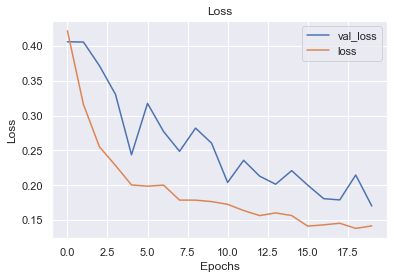

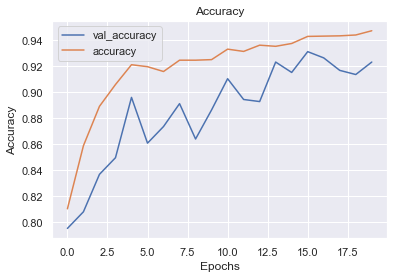

In [325]:
# Plot accuracy and loss
visualize_training_results(history_3)

In [326]:
# Generate predictions

predictions = model_3.predict(test_images)

predictions[:10]

array([[0.99999374],
       [0.99999017],
       [0.99927056],
       [0.340195  ],
       [0.9946703 ],
       [0.95612615],
       [0.47263592],
       [0.99999964],
       [0.9976728 ],
       [0.56795484]], dtype=float32)

In [327]:
y_hat_test = np.round(predictions)

In [328]:
y_hat_test[:10]

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [329]:
# RMSE on test data
from sklearn.metrics import mean_squared_error

print("MEAN SQUARED ERROR:")
np.sqrt(mean_squared_error(test_labels, y_hat_test))

MEAN SQUARED ERROR:


0.41602516

In [330]:
# Display confusion matrix

print('Confusion Matrix')
print(confusion_matrix(test_labels, y_hat_test))

Confusion Matrix
[[144  90]
 [ 18 372]]


In [332]:
#print classification_report

print(classification_report(test_labels, y_hat_test))

#target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

              precision    recall  f1-score   support

         0.0       0.89      0.62      0.73       234
         1.0       0.81      0.95      0.87       390

    accuracy                           0.83       624
   macro avg       0.85      0.78      0.80       624
weighted avg       0.84      0.83      0.82       624



#### Model 3 Summary 

Padding was added to the model to extend the area available for analysis to the convolutional layers. Increased strides were also introduced to allow for some compression of the resulting feature maps in each layer. The optimizer was also changed to 'adam' to allow for increased adaptive learning rates to be applied to each parameter. Very little changes in accuracy were realized from the previous model: model_2. The generated classification report provides deeper insight into recall and precision. Recall rate for pneumonia was quite strong at 99% suggesting the model is capable of catching most cases of pneumonia in test data, but at the expense of generating numerous false positive cases. Based on recall half of the cases that were predicted for pneumonia do not actually have pneumonia. 

## Model 4 - Added layering and regularization (L2 and dropouts)


In [333]:
#Instantiate a CNN model, 
# L2 Regularize on the model steps with greatest amount of parameters. 

img_size = 150

model_4 = Sequential()

# Add convolution layer with alternating strides

model_4.add(Conv2D(8, (3, 3), 
                   padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))

# Add a maxpooling layer

model_4.add(MaxPooling2D(pool_size=(2, 2), strides = 2))


#Layer 2
model_4.add(Conv2D(16, (3, 3), padding = 'same', strides = 1,  
                   activation='relu'))

model_4.add(MaxPooling2D((2, 2), strides = 2))

#Layer 3
model_4.add(Conv2D(32, (3, 3), padding = 'same', strides = 1,  
                   activation='relu'))

model_4.add(MaxPooling2D((2, 2), strides = 2))


#Layer 4
model_4.add(Conv2D(64, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))


model_4.add(MaxPooling2D((2, 2), strides = 2))


#Layer 5
model_4.add(Conv2D(128, (3, 3), padding = 'same', strides = 1, 
                   kernel_regularizer =tf.keras.regularizers.l2( l=0.005), 
                   activation='relu'))


model_4.add(MaxPooling2D((2, 2), strides = 2))
# Flatten the model

model_4.add(Flatten())

# Add dense layers, two hidden

model_4.add(Dense(128,  kernel_regularizer =tf.keras.regularizers.l2(l=0.005), 
                  activation = 'relu'))
model_4.add(Dropout(0.2))

# Add the output layer for binary - normal or pneumonia

model_4.add(Dense(1))
model_4.add(Activation('sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [334]:
model_4.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 150, 150, 8)       224       
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 75, 75, 16)        1168      
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 37, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 18, 18, 64)      

In [335]:
history_4 = model_4.fit(train_generator, 
                       epochs = 30, 
                       validation_data=val_generator)

Epoch 1/30
144/144 [==============================] - 86s 599ms/step - loss: 0.9112 - accuracy: 0.7410 - val_loss: 0.6270 - val_accuracy: 0.7440
Epoch 2/30
144/144 [==============================] - 85s 590ms/step - loss: 0.5237 - accuracy: 0.7637 - val_loss: 0.4918 - val_accuracy: 0.7824
Epoch 3/30
144/144 [==============================] - 85s 588ms/step - loss: 0.3819 - accuracy: 0.8342 - val_loss: 0.3703 - val_accuracy: 0.8304
Epoch 4/30
144/144 [==============================] - 85s 593ms/step - loss: 0.3361 - accuracy: 0.8654 - val_loss: 0.3409 - val_accuracy: 0.8464
Epoch 5/30
144/144 [==============================] - 85s 593ms/step - loss: 0.3371 - accuracy: 0.8593 - val_loss: 0.4307 - val_accuracy: 0.8160
Epoch 6/30
144/144 [==============================] - 85s 593ms/step - loss: 0.3267 - accuracy: 0.8700 - val_loss: 0.3558 - val_accuracy: 0.8320
Epoch 7/30
144/144 [==============================] - 85s 592ms/step - loss: 0.3091 - accuracy: 0.8765 - val_loss: 0.5336 - val_ac

#### Evaluate Model 4

In [336]:
# Results for train, val and test
results_4_train = model_4.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 829us/step - loss: 0.1630 - accuracy: 0.9375


In [337]:
results_4_test = model_4.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 36ms/step - loss: 0.4487 - accuracy: 0.7949


In [338]:
results_4_val = model_4.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.1646 - accuracy: 1.0000


In [339]:
#Print results for Model 4 train and test
print("Model 4 Results from Training Data:", results_4_train)
print()
print("Model 4 Results from Test Data:", results_4_test)


Model 4 Results from Training Data: [0.16297994554042816, 0.9375]

Model 4 Results from Test Data: [0.44867217540740967, 0.7948718070983887]


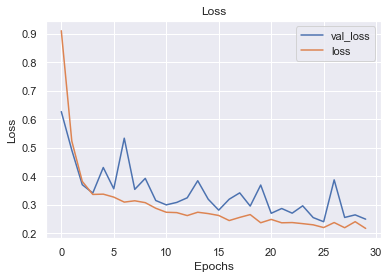

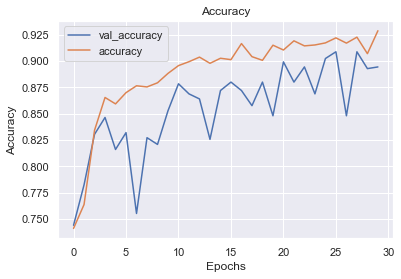

In [340]:
# Plot Loss and Accuracy
visualize_training_results(history_4)

In [341]:
# Generate predictions
predictions = model_4.predict(test_images)
y_pred = np.round(predictions)
y_pred[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [342]:
cm_4 = confusion_matrix(test_labels, y_pred)
cm_4

array([[118, 116],
       [ 12, 378]])

In [343]:
import itertools

In [344]:
# Create a function to plot confusion matrix. Thanks to deep lizard resources.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [345]:
#Confirm indices of each class
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[118 116]
 [ 12 378]]


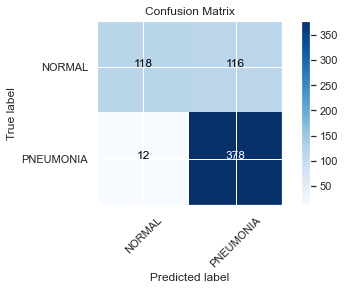

In [346]:
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm_4, classes=cm_plot_labels, title='Confusion Matrix')

In [347]:
print(classification_report(test_labels, y_pred, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.91      0.50      0.65       234
Pneumonia (Class 1)       0.77      0.97      0.86       390

           accuracy                           0.79       624
          macro avg       0.84      0.74      0.75       624
       weighted avg       0.82      0.79      0.78       624



#### model 4 summary


### Model 5  - Regularization of Model_4

In [366]:
#Instantiate a CNN model
model_5 = Sequential()

# Apply 4 Convolution with Maxpooling with regularization: Dropouts, L2, Normalization

#Layer1
model_5.add(Conv2D(8, (3, 3), 
                   padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))
model_5.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_5.add(Dropout(0.2))


#Layer2
model_5.add(Conv2D(16, (3, 3), kernel_regularizer =tf.keras.regularizers.l2(l=0.005),
                   padding = 'same', strides = 1, activation='relu'))
model_5.add(MaxPooling2D((2, 2), strides = 2))
model_5.add(Dropout(0.2))

#Layer3
model_5.add(Conv2D(64, (3, 3), kernel_regularizer =tf.keras.regularizers.l2(l=0.005),
                   padding = 'same', strides = 1, activation='relu'))
model_5.add(MaxPooling2D((2, 2), strides = 2))
model_5.add(Dropout(0.2))

#Layer4
model_5.add(Conv2D(128, (4, 4), 
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.005),
                   padding = 'same', strides = 1, activation='relu'))
model_5.add(MaxPooling2D((2, 2), strides = 2))
model_5.add(Dropout(0.2))


# Flatten the model
model_5.add(Flatten())

# Add dense layers
model_5.add(Dense(128,  kernel_regularizer =tf.keras.regularizers.l2(l=0.005), activation = 'relu'))
model_5.add(Dense(12, activation = 'relu'))
model_5.add(Dense(7, activation = 'relu'))
model_5.add(Dense(5, activation = 'relu'))
#model_5.add(Dropout(0.2))

# Add the output layer for binary - normal or pneumonia

model_5.add(Dense(1, activation = 'sigmoid'))

# Compile the model with binary cross entropy as loss and 'adam' for optimizer

model_5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [367]:
model_5.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_123 (Conv2D)          (None, 150, 150, 8)       224       
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 75, 75, 8)         0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 75, 75, 16)        1168      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 37, 37, 16)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 37, 37, 64)      

In [381]:
history_5 = model_5.fit(train_generator, 
                       epochs = 64, 
                       validation_data=val_generator)

Epoch 1/64
144/144 [==============================] - 91s 635ms/step - loss: 0.2918 - accuracy: 0.9052 - val_loss: 0.3050 - val_accuracy: 0.8928
Epoch 2/64
144/144 [==============================] - 91s 632ms/step - loss: 0.2876 - accuracy: 0.9048 - val_loss: 0.3437 - val_accuracy: 0.8704
Epoch 3/64
144/144 [==============================] - 91s 630ms/step - loss: 0.2726 - accuracy: 0.9127 - val_loss: 0.3254 - val_accuracy: 0.8784
Epoch 4/64
144/144 [==============================] - 91s 631ms/step - loss: 0.2981 - accuracy: 0.9002 - val_loss: 0.3020 - val_accuracy: 0.8816
Epoch 5/64
144/144 [==============================] - 91s 634ms/step - loss: 0.2780 - accuracy: 0.9090 - val_loss: 0.3059 - val_accuracy: 0.8656
Epoch 6/64
144/144 [==============================] - 91s 631ms/step - loss: 0.2746 - accuracy: 0.9098 - val_loss: 0.3435 - val_accuracy: 0.8736
Epoch 7/64
144/144 [==============================] - 91s 633ms/step - loss: 0.2649 - accuracy: 0.9148 - val_loss: 0.3476 - val_ac

144/144 [==============================] - 90s 626ms/step - loss: 0.2398 - accuracy: 0.9268 - val_loss: 0.3797 - val_accuracy: 0.8512
Epoch 58/64
144/144 [==============================] - 91s 629ms/step - loss: 0.2327 - accuracy: 0.9240 - val_loss: 0.2544 - val_accuracy: 0.8976
Epoch 59/64
144/144 [==============================] - 91s 631ms/step - loss: 0.2348 - accuracy: 0.9220 - val_loss: 0.2809 - val_accuracy: 0.8976
Epoch 60/64
144/144 [==============================] - 91s 631ms/step - loss: 0.2667 - accuracy: 0.9105 - val_loss: 0.2966 - val_accuracy: 0.8800
Epoch 61/64
144/144 [==============================] - 90s 628ms/step - loss: 0.2261 - accuracy: 0.9251 - val_loss: 0.2464 - val_accuracy: 0.9024
Epoch 62/64
144/144 [==============================] - 91s 630ms/step - loss: 0.2303 - accuracy: 0.9281 - val_loss: 0.2320 - val_accuracy: 0.9120
Epoch 63/64
144/144 [==============================] - 91s 633ms/step - loss: 0.2306 - accuracy: 0.9264 - val_loss: 0.2158 - val_accurac

In [382]:
results_5_train = model_5.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.2278 - accuracy: 0.9062


In [383]:
results_5_test = model_5.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 41ms/step - loss: 0.3577 - accuracy: 0.8798


In [384]:
results_5_val = model_5.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 721us/step - loss: 0.2304 - accuracy: 0.9062


#### Evaluate Model 5

In [573]:
#Print results for Model 5 train and test
print("Model 5 Results from Training Data:", results_5_train)
print()
print("Model 5 Results from Test Data:", results_5_test)

Model 5 Results from Training Data: [0.22779732942581177, 0.90625]

Model 5 Results from Test Data: [0.3577389717102051, 0.879807710647583]


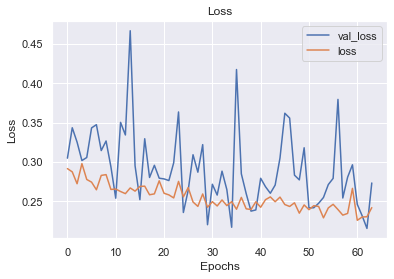

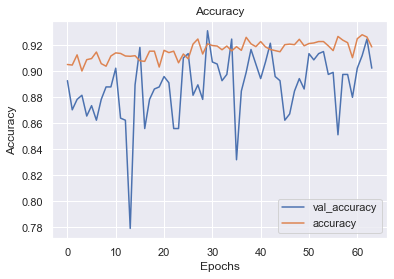

In [386]:
#plot loss and accuracy
visualize_training_results(history_5)

In [387]:
# Generate predictions on test set
predictions = model_5.predict(test_images)

#y_hat_test = np.argmax(predictions, axis = 1)
# or
#np.round(predictions)


In [388]:
predictions[:10]

array([[0.99459934],
       [0.9927358 ],
       [0.96664536],
       [0.80159473],
       [0.8569169 ],
       [0.46368176],
       [0.24891579],
       [0.9982353 ],
       [0.9772525 ],
       [0.16875297]], dtype=float32)

In [389]:
y_pred = np.round(predictions)
y_pred[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [390]:
cm_5 = confusion_matrix(test_labels, y_pred)
cm_5

array([[182,  52],
       [ 23, 367]])

In [391]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[182  52]
 [ 23 367]]


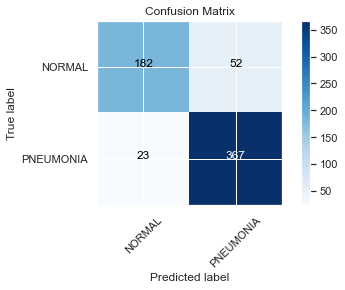

In [392]:

cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm_5, classes=cm_plot_labels, title='Confusion Matrix')

In [393]:
print(classification_report(test_labels, y_pred, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.89      0.78      0.83       234
Pneumonia (Class 1)       0.88      0.94      0.91       390

           accuracy                           0.88       624
          macro avg       0.88      0.86      0.87       624
       weighted avg       0.88      0.88      0.88       624



#### Model 5 summary 

Model 5 included regularization through using L2 reguylarization and adding consistent dropouts of 20%. This model improved on recall scores for detecting normal lungs, a more satisfactory result at the cost of slight recall reduction on pneumonia detection. The model learned quickly at the beginning with oscillating validation results in both loss and accuracy, the model had a difficult time identifying the minimum. Despite this the training and test results are within a few percentage points of one another, this model reduced overfitting compared to previous models. 


### Model 5a - tuning learning rate and adding a callback

Adjust the learning rate to a smaller rate and add a callback to prevent overfitting of model 5.  

In [569]:
#Instantiate a CNN model
model_5a = Sequential()

# Apply 4 Convolution with Maxpooling with regularization: Dropouts, L2, Normalization

#Layer1
model_5a.add(Conv2D(8, (3, 3), 
                   padding = 'same', strides = 1, activation = 'relu',
                   input_shape= (img_size, img_size, 3)))
model_5a.add(MaxPooling2D(pool_size=(2, 2), strides = 2))
model_5a.add(Dropout(0.2))


#Layer2

model_5a.add(Conv2D(16, (3, 3), kernel_regularizer =tf.keras.regularizers.l2(l=0.005),
                   padding = 'same', strides = 1, activation='relu'))
                    
model_5a.add(MaxPooling2D((2, 2), strides = 2))
model_5a.add(Dropout(0.2))

#Layer3

model_5a.add(Conv2D(64, (3, 3), kernel_regularizer =tf.keras.regularizers.l2(l=0.005),
                   padding = 'same', strides = 1, activation='relu'))
model_5a.add(MaxPooling2D((2, 2), strides = 2))
model_5a.add(Dropout(0.2))

#Layer4  
model_5a.add(Conv2D(128, (3, 3),
                   kernel_regularizer =tf.keras.regularizers.l2(l=0.005),
                   padding = 'same', strides = 1, activation='relu'))
model_5a.add(MaxPooling2D((2, 2), strides = 2))
model_5a.add(Dropout(0.2))


# Flatten the model
model_5a.add(Flatten())

# Add dense layers
model_5a.add(Dense(128,  kernel_regularizer =tf.keras.regularizers.l2(l=0.005), activation = 'relu'))
model_5a.add(Dropout(0.2))
model_5a.add(Dense(12, activation = 'relu'))
model_5a.add(Dense(7, activation = 'relu'))
model_5a.add(Dense(5, activation = 'relu'))


# Add the output layer for binary - normal or pneumonia

model_5a.add(Dense(1, activation = 'sigmoid'))

model_5a.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [570]:
model_5a.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_257 (Conv2D)          (None, 150, 150, 8)       224       
_________________________________________________________________
max_pooling2d_224 (MaxPoolin (None, 75, 75, 8)         0         
_________________________________________________________________
dropout_178 (Dropout)        (None, 75, 75, 8)         0         
_________________________________________________________________
conv2d_258 (Conv2D)          (None, 75, 75, 16)        1168      
_________________________________________________________________
max_pooling2d_225 (MaxPoolin (None, 37, 37, 16)        0         
_________________________________________________________________
dropout_179 (Dropout)        (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_259 (Conv2D)          (None, 37, 37, 64)      

In [571]:
from keras import callbacks

# Set early stopping for validation loss with patience
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

In [572]:
history_5a = model_5a.fit(train_generator, 
                       epochs = 64, 
                       validation_data=val_generator, 
                       callbacks = [earlystopping])

Epoch 1/64
144/144 [==============================] - 91s 633ms/step - loss: 1.8797 - accuracy: 0.7404 - val_loss: 1.4855 - val_accuracy: 0.7440
Epoch 2/64
144/144 [==============================] - 90s 624ms/step - loss: 1.2202 - accuracy: 0.7428 - val_loss: 1.1141 - val_accuracy: 0.7440
Epoch 3/64
144/144 [==============================] - 90s 627ms/step - loss: 0.9621 - accuracy: 0.7428 - val_loss: 0.9385 - val_accuracy: 0.7440
Epoch 4/64
144/144 [==============================] - 90s 626ms/step - loss: 0.8384 - accuracy: 0.7428 - val_loss: 0.8613 - val_accuracy: 0.7440
Epoch 5/64
144/144 [==============================] - 90s 624ms/step - loss: 0.7530 - accuracy: 0.7432 - val_loss: 0.8200 - val_accuracy: 0.7360
Epoch 6/64
144/144 [==============================] - 91s 630ms/step - loss: 0.7117 - accuracy: 0.7493 - val_loss: 0.7470 - val_accuracy: 0.7440
Epoch 7/64
144/144 [==============================] - 90s 626ms/step - loss: 0.6729 - accuracy: 0.7467 - val_loss: 0.7141 - val_ac

144/144 [==============================] - 90s 622ms/step - loss: 0.3325 - accuracy: 0.8880 - val_loss: 0.4089 - val_accuracy: 0.8464


#### Model evaluation

In [574]:
results_5a_train = model_5a.evaluate(train_images, train_labels)

1/1 [==============================] - 0s 1ms/step - loss: 0.3926 - accuracy: 0.8438


In [575]:
results_5a_test = model_5a.evaluate(test_images, test_labels)

20/20 [==============================] - 1s 43ms/step - loss: 0.5117 - accuracy: 0.7949


In [576]:
results_5a_val = model_5a.evaluate(val_images, val_labels)

1/1 [==============================] - 0s 930us/step - loss: 0.3633 - accuracy: 0.8438


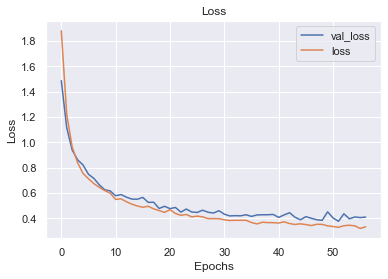

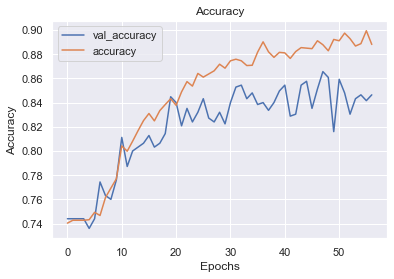

In [577]:
visualize_training_results(history_5a)

In [578]:
# Generate predictions on test set
predictions = model_5a.predict(test_images)
y_pred = np.round(predictions)
y_pred[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [579]:
cm_5a = confusion_matrix(test_labels, y_pred)
cm_5a

array([[116, 118],
       [ 10, 380]])

In [580]:
print(classification_report(test_labels, y_pred, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.92      0.50      0.64       234
Pneumonia (Class 1)       0.76      0.97      0.86       390

           accuracy                           0.79       624
          macro avg       0.84      0.74      0.75       624
       weighted avg       0.82      0.79      0.78       624



#### model 5a summary

This model kept the same layers and paremeters as model 5 but included an adjusted learning rate of 0.0001 and a callback to end the training if no validation loss was observed after 5 epochs. While recall accuracy score improved on pneumonia identification (97%), recall accuracy fared worse with no better than chance accuracy. Model 5 is a better model for our business case. 

In [586]:
#save model 5 as final model

final_model = model_5
final_model.save_weights('final_model.h5')

## Final Summary

It is possible to keep tuning and adding or subtracting layers. After 7 model iterations, including the baseline model, model 5 delivers the most acceptable results based upon accuracy scores and narrowness in accuracy scores between the training dataset and the test dataset. While some overfitting exists, model 5 offers the most narrow results between training and testing data.

In [592]:
#Print results for Model 5 train and test
print("Model 5 Results from Training Data, loss and accuracy:", results_5_train)
print()
print("Model 5 Results from Test Data, loss and accuracy:", results_5_test)

Model 5 Results from Training Data, loss and accuracy: [0.22779732942581177, 0.90625]

Model 5 Results from Test Data, loss and accuracy: [0.3577389717102051, 0.879807710647583]


Model 5 also delivered more promising results on test data when it comes to accurately predicting true cases of pneumonia and true cases of normal lungs while minimizing the numbers of false negative cases of pneumonia. Considering we are working with pediatric patients who are susceptible to harm, even death, from pneumonia, it is critical the model minimizes false negatives. 

While the number of 52 false positives is higher than 23 false negatives in the test set, this is a more acceptable outcome when it comes to patient care because we trying to catch as many cases of pneumonia as possible. While potentially a scary scenario for the patient and their family who receive a false positive diagnosis, ultimately they do not have pneumonia. 

The classification report details the model's precision and accuracy per model class:

                                precision    recall  f1-score   support

              Normal (Class 0)       0.89      0.78      0.83       234
           Pneumonia (Class 1)       0.88      0.94      0.91       390

                      accuracy                           0.88       624


The number of false positives in model 5 is also far lower than in previous iterations of the model making for a more acceptable outcome. Model 5a, where the learning rate was decreased and the callback function was applied, delivered lower numbers of false negatives, it came at a high cost of no better than a chance score of 50% recall on identifying if a patient had normal lungs. Any scores of close to only chance in recall calls for discarding that model iteration. 

Confusion matrix, without normalization
[[182  52]
 [ 23 367]]


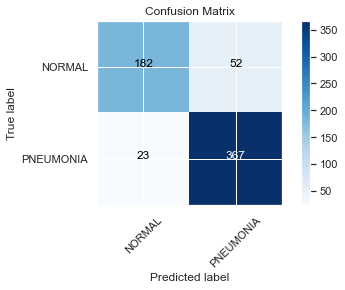

In [588]:
plot_confusion_matrix(cm=cm_5, classes=cm_plot_labels, title='Confusion Matrix')
plt.savefig('model_5_cm.png')

## Recommendations

### 1. 
The final model can be prototyped in the clinic for pediatric patients with a 91% pneumonia f-1 accuracy rate. Wait times for radiology results are often the cause of delay in diagnosis times. Use of the model can reduce diagnosis turnaround times to reduce costs and improve patient outcomes. 

### 2. 
Neural network models are often useful for other problems. This model can be trained on images for other groups of patients, particularly the elderly who suffer poorer outcomes from pneumonia. Gathering quality controlled images of lungs of elderly patients to train a new model for deployment would be beneficial for rapid assessment and diagnosis, improved patient outcomes and reduced costs. 

#### Model Limitations
There are two important things to note about the model. The first is that the model identifies whether a patient has pneumonia or not with a higher rate of false positives compared to false negatives, a better outcome for patients with pneumonia at the cost of some false positives. The second is that the model does not discriminate among viral, bacterial, or fungal origins. It also does not identify whether pneumonia is community or hospital acquired. Clinicians and radiologists will still need to be involved in key stages after diagnosis of pneumonia.